In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect("../db/baltasar.db")
def sql(query):
    return pd.read_sql_query(query, conn)

High-Degree Addresses can be categorized into three groups:
1. Dilluters (High distinct outdegree, high distinct indegree)
2. Mixers (Similar in and out degrees)
3. Concentrators (High in degree, low outdegree)

(12516, 17)


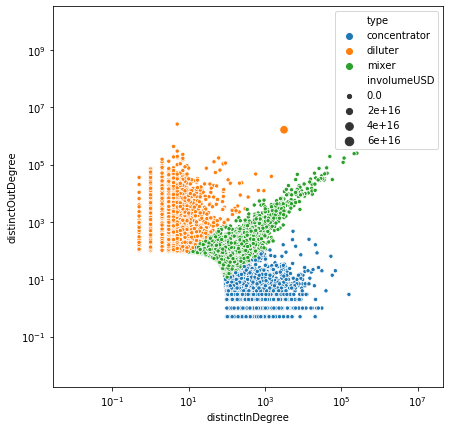

In [6]:
df = sql('SELECT * FROM AddressMetadata WHERE distinctDegree >= 100')

print(df.shape)
df['type'] = "n/a"
df.loc[df['distinctInDegree'] == 0, ['distinctInDegree']] = 0.5
df.loc[df['distinctOutDegree'] == 0, 'distinctOutDegree'] = 0.5

df.loc[df['isDiluter'] == 1, ['type']] = 'diluter'
df.loc[df['isMixer'] == 1, ['type']] = 'mixer'
df.loc[df['isConcentrator'] == 1, ['type']] = 'concentrator'

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x='distinctInDegree', y='distinctOutDegree', hue="type", size="involumeUSD", data=df, ax=ax)

In [12]:
transfer_df = sql('''SELECT isFromConcentrator, isToConcentrator, isFromDiluter, isToDiluter, isFromMixer, isToMixer, isIntoDepositAddress, count(*) as numTransfers, round(sum(amountInUSDCurrent)/1000000) as volume
FROM Transfer
GROUP BY isFromConcentrator, isToConcentrator, isFromDiluter, isToDiluter, isFromMixer, isToMixer, isIntoDepositAddress''')


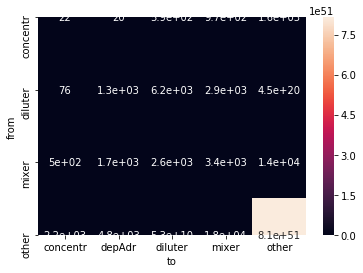

In [21]:
transfer_df['to'] = 'other'
transfer_df['from'] = 'other'

transfer_df.loc[transfer_df['isFromConcentrator'] == 1, ['from']] = 'concentr'
transfer_df.loc[transfer_df['isFromMixer'] == 1, ['from']] = 'mixer'
transfer_df.loc[transfer_df['isFromDiluter'] == 1, ['from']] = 'diluter'

transfer_df.loc[transfer_df['isToConcentrator'] == 1, ['to']] = 'concentr'
transfer_df.loc[transfer_df['isToMixer'] == 1, ['to']] = 'mixer'
transfer_df.loc[transfer_df['isToDiluter'] == 1, ['to']] = 'diluter'
transfer_df.loc[(transfer_df['isIntoDepositAddress'] == 1) & (transfer_df['to'] == 'other'), ['to']] = 'depAdr'

#transfer_df['numTransfers'] = transfer_df['numTransfers'] * 1000
pivot = pd.pivot_table(transfer_df, values='numTransfers', index=['from'], columns=['to'])

sns.heatmap(data=pivot, annot=True)

#pivot_volume = pd.pivot_table(transfer_df, values='volume', index=['from'], columns=['to'])
#sns.heatmap(data=pivot_volume, annot=True)

In [ ]:
sql('''SELECT count(distinct a) as addressesWithLabeledTransfer, (SELECT count(*) FROM Address) as allAddresses
FROM
	(SELECT `to` as a FROM Transfer 
		WHERE isFromConcentrator = 1 OR isFromDiluter = 1 OR isFromMixer = 1 OR isIntoDepositAddress = 1 OR isToConcentrator = 1 OR isToDiluter = 1 OR isToMixer = 1
	UNION ALL
	SELECT `from` as a FROM Transfer 
		WHERE isFromConcentrator = 1 OR isFromDiluter = 1 OR isFromMixer = 1 OR isIntoDepositAddress = 1 OR isToConcentrator = 1 OR isToDiluter = 1 OR isToMixer = 1) tos''')

In [11]:
sql('''SELECT isEarlyTransfer, isVeryEarlyTransfer, count(*) FROM Transfer group by isEarlyTransfer, isVeryEarlyTransfer''')

,isEarlyTransfer,isVeryEarlyTransfer,count(*)
0,0,0,52593436
1,1,0,2494317
2,1,1,288620
